In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as stats
import math as m

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Animal Welfare Center dataset

In [3]:
original_data = pd.read_csv("kaggle_files/animal_welfare_center.csv")

In [4]:
data = original_data.copy()

In [5]:
data.head()

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [6]:
data.outcome_type.value_counts()

Adoption           12967
Transfer           10345
Return to Owner     9718
Euthanasia          4144
Died                2829
Missing             2599
Relocate            2573
Rto-Adopt           2450
Disposal             178
Name: outcome_type, dtype: int64

#### We will focus only on the animals with a "positive" outcome, trying to build a model for the time spent at the shelter.

In [7]:
data = data[data['outcome_type'].isin(["Adoption", "Rto-Adopt", "Return to Owner"])] 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25135 entries, 0 to 47801
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           25135 non-null  object 
 1   dob_year                    25135 non-null  int64  
 2   dob_month                   25135 non-null  int64  
 3   age_upon_intake             25135 non-null  object 
 4   animal_type                 25135 non-null  object 
 5   breed                       25135 non-null  object 
 6   color                       25135 non-null  object 
 7   intake_condition            25135 non-null  object 
 8   intake_type                 25135 non-null  object 
 9   sex_upon_intake             25134 non-null  object 
 10  count                       25135 non-null  int64  
 11  age_upon_intake_(days)      25135 non-null  int64  
 12  age_upon_intake_(years)     25135 non-null  float64
 13  age_upon_intake_age_group   251

## Data Cleaning

In [9]:
# List of columns that have unnecessary/redundant information
drop_columns = ["age_upon_intake", "count", "age_upon_intake_(days)", "intake_datetime", "time_in_shelter",
                "intake_monthyear" , "age_upon_outcome", "date_of_birth", "age_upon_outcome_(days)",
                "age_upon_intake_age_group", "age_upon_outcome_age_group",
                "outcome_datetime", "outcome_monthyear", "outcome_number", "intake_hour", "outcome_hour"]

In [10]:
# select numerical features for correlations
numerical = data.select_dtypes(np.number)

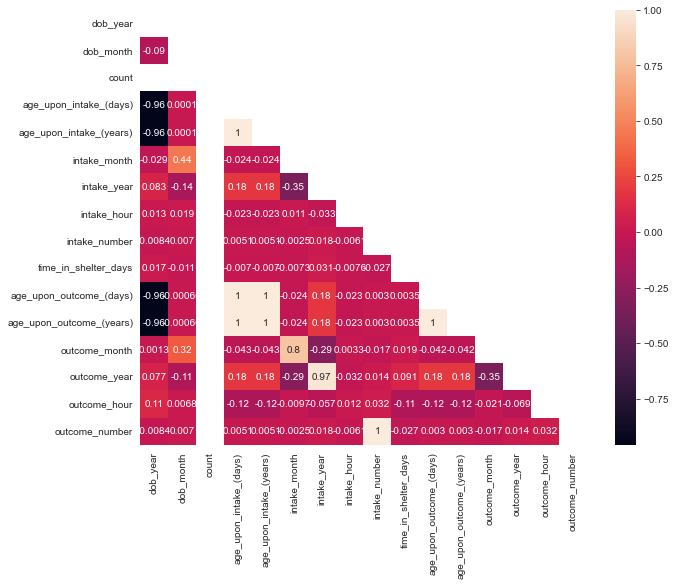

In [11]:
correlations = numerical.corr() # create the correlations

mask = np.zeros_like(correlations) # create an array with size of correlations

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations, mask=mask, annot=True)
plt.show()

#### Outcome and income values are almost the same because the duration that animals spent at the center are generally short, therefore high correlations. More columns need to be dropped.

In [12]:
# Dropping more columns after reducing the data
drop_columns.extend(["dob_year", "age_upon_outcome_(days)", "age_upon_outcome_(years)", "outcome_year"]) # use extend([]) instead of multiple append()

In [13]:
len(data.animal_id_outcome.unique())/len(data) # how many unique animals are in the dataset

0.877501491943505

#### The data has multiple entries for the same animal. The duplicates will be dropped.

In [14]:
# Remove duplicate rows for same animal
data = data[data['intake_number'] == 1]

In [15]:
# now useless columns
drop_columns.extend(["animal_id_outcome", "intake_number"]) # use extend([]) instead of multiple append()

data = data.drop(columns=drop_columns)                      # dropping unnecessary columns

In [16]:
# Change column names for better understanding
data.rename(columns={'age_upon_intake_(years)':'age(years)',
                        "sex_upon_intake" : "sex"}, inplace=True)

In [17]:
# Exploring the values in our data to look for values that are unclear
for i in data.columns:
        print("------------------------")
        x = data[i].value_counts()
        print(x)

------------------------
4     2206
3     1991
5     1878
10    1782
6     1715
8     1682
9     1676
1     1675
12    1669
7     1634
2     1559
11    1517
Name: dob_month, dtype: int64
------------------------
Dog      14705
Cat       6147
Other       74
Bird        58
Name: animal_type, dtype: int64
------------------------
Domestic Shorthair Mix                             4683
Pit Bull Mix                                       1704
Chihuahua Shorthair Mix                            1578
Labrador Retriever Mix                             1302
German Shepherd Mix                                 580
                                                   ... 
American Staffordshire Terrier/American Bulldog       1
Jack Russell Terrier/Miniature Schnauzer              1
Boxer/Cardigan Welsh Corgi                            1
Pembroke Welsh Corgi/Pit Bull                         1
Mastiff/Bloodhound                                    1
Name: breed, Length: 1426, dtype: int64
---------------

In [18]:
no_age = data[data["age(years)"]==0]                                           # select data where age is 0
no_age_list= list(no_age[(no_age.dob_month - no_age.intake_month ) >0 ].index) # get list of those indices 
data.loc[no_age_list, "dob_month"] = data["dob_month"] - 1                     # reduce dob_month by 1 to match intake_month

In [19]:
data

,dob_month,animal_type,breed,color,intake_condition,intake_type,sex,age(years),intake_month,intake_year,intake_weekday,time_in_shelter_days,sex_upon_outcome,outcome_month,outcome_weekday,outcome_type
0,7,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,10.000000,12,2017,Thursday,0.588194,Neutered Male,12,Thursday,Return to Owner
4,10,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,16.000000,11,2013,Saturday,0.119444,Neutered Male,11,Saturday,Return to Owner
5,6,Dog,Labrador Retriever/Pit Bull,Black/White,Aged,Stray,Spayed Female,15.000000,11,2013,Saturday,0.870833,Spayed Female,11,Sunday,Return to Owner
6,10,Dog,Miniature Schnauzer Mix,Black/Gray,Normal,Stray,Intact Female,15.000000,11,2014,Friday,0.178472,Intact Female,11,Friday,Return to Owner
7,8,Dog,Lhasa Apso Mix,Brown/White,Normal,Stray,Neutered Male,15.000000,9,2014,Monday,0.213194,Neutered Male,9,Monday,Return to Owner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47797,1,Dog,Dachshund Mix,Red,Normal,Public Assist,Intact Female,0.082192,3,2016,Sunday,0.019444,Intact Female,3,Sunday,Return to Owner
47798,9,Cat,Domestic Longhair Mix,Black/White,Normal,Stray,Neutered Male,8.000000,3,2016,Sunday,21.525000,Neutered Male,4,Monday,Rto-Adopt
47799,3,Dog,Cairn Terrier Mix,Gray/White,Normal,Owner Surrender,Intact Male,1.000000,3,2016,Sunday,2.306944,Neutered Male,3,Tuesday,Adoption
47800,3,Dog,Shetland Sheepdog Mix,Brown/Tan,Normal,Stray,Spayed Female,11.000000,3,2016,Sunday,0.224306,Spayed Female,3,Sunday,Return to Owner


#### The zeros in the "age_upon_intake_(years)" are not missing values, they indicate a very young (or new born) animal at the Center. Some wrong values were cleaned.

In [20]:
data["sex"] = data['sex'].replace('Unknown', np.NaN)  # Replacing "Unknown" strings with Nans

In [21]:
data.sex.value_counts(dropna =False)/len(data) # How much of the data are NaNs now?

Intact Male      0.304422
Intact Female    0.271350
Neutered Male    0.220072
Spayed Female    0.196102
NaN              0.008054
Name: sex, dtype: float64

#### Filling missing values randomly with values from that column.

In [22]:
def random_nans(df, col):                                   # take the dataframe and the specified column
    print("NaNs before:", df[col].isna().sum())             # sanity check for NaNs before removing
    
    x = df.copy()                                           # copy dataframe for mask
    mask = df[col].isna()                                   # create the mask correlating to NaNs
    sexes = df[col].dropna().unique()                       # get unique entries in specified column
    
    x.loc[mask, col] = random.choices(sexes, weights = [3,3,2,2],k=mask.sum()) # apply mask to copied dataframe and replace NaNs 
                                                            # with random entries from the list
    print("NaNs after:" , x[col].isna().sum())              # sanity check for NaNs after removing
    return x

In [23]:
data = random_nans(data, "sex")

NaNs before: 169
NaNs after: 0


In [24]:
def group_by_value(data,col,num,rename):                         # take 4 arguments: dataframe, column to modify,
                                                                 # cut of number and string u want to rename the NaNs to
    data2 = data.copy()
    
    breed1 = pd.DataFrame([data2[col].value_counts()<num]).T     # select dataframe where column has values less than specified
    mask1 = breed1.loc[breed1[col]==True].index                  # create mask with index of selected data
    df1 = data2[data2[col].isin(mask1)]                          # create dataframe with mask
    df1[col] = rename                                            # rename all entries in column

    #similar to code above, this time with values >= to specified number
    breed2 = pd.DataFrame([data2[col].value_counts()>=num]).T
    mask2 = breed2.loc[breed2[col]==True].index
    df2 = data2[data2[col].isin(mask2)]

    df = pd.concat([df1,df2] , axis = 0)                          # Combine modified dataframe with unmodified 
    
    print("The", col, "column now has", len(df[col].value_counts()), "unique entries")
    return df

In [25]:
data = group_by_value(data, "breed", 100, "Other")
data = group_by_value(data,"color", 120, "Other")

The breed column now has 26 unique entries
The color column now has 39 unique entries


In [26]:
data = data.reset_index(drop=True)

## Data Exploration

In [27]:
iqr = np.percentile(data["time_in_shelter_days"], 75) - np.percentile(data["time_in_shelter_days"], 25)
upper_limit = np.percentile(data["time_in_shelter_days"], 75) + 1.5 * iqr
lower_limit = np.percentile(data["time_in_shelter_days"], 25) - 1.5 * iqr

mask_outlier = (data.time_in_shelter_days > upper_limit) | (data.time_in_shelter_days < lower_limit) # condition of being an outlier
mask_not_outlier = ( data.time_in_shelter_days <= upper_limit) & (data.time_in_shelter_days >= lower_limit) # condition of not not being outlier 
outliers_time_in_shelter_days = data[mask_outlier] # here it is the dataset with the outliers of time_in_shelter_days
cleaned_outliers_time_in_shelter_days = data[mask_not_outlier ] # here we have the dataset without outliers of time_in_shelter_days
#display(cleaned_outliers)

data_no_outl = data[(data.time_in_shelter_days < upper_limit) & (data.time_in_shelter_days > lower_limit)]
print("Shape of dataset with outliers:", data.shape)
print("Shape of dataset without outliers:", data_no_outl.shape)

Shape of dataset with outliers: (20984, 16)
Shape of dataset without outliers: (18070, 16)


<AxesSubplot:ylabel='Density'>

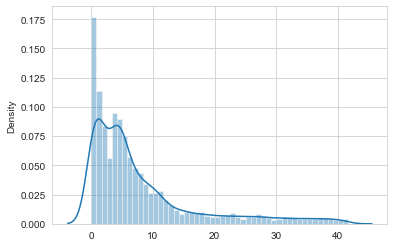

In [28]:
# VISUALIZE VARIABLES VS TARGET
y = data_no_outl.time_in_shelter_days
sns.distplot(x=y)

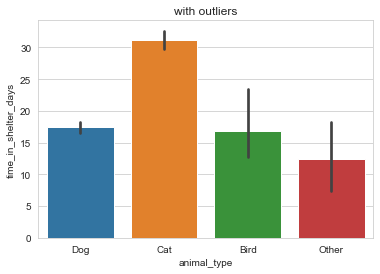

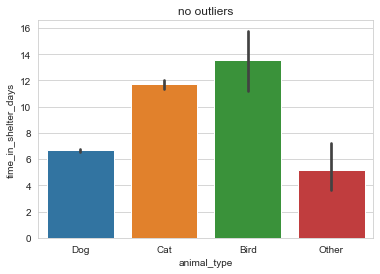

In [29]:
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data) # mean of the 3 categories
plt.title("with outliers")
plt.show()
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data_no_outl) # mean of the 3 categories
plt.title("no outliers")
plt.show()

In [30]:
# average time in shelter by type
print("with outliers:" ,data[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean())
print("-------------")
print("no outliers:" ,data_no_outl[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean()) 

with outliers: animal_type
Bird     16.903257
Cat      31.245074
Dog      17.408520
Other    12.408164
Name: time_in_shelter_days, dtype: float64
-------------
no outliers: animal_type
Bird     13.550227
Cat      11.691861
Dog       6.659396
Other     5.187687
Name: time_in_shelter_days, dtype: float64


# What can we see here?

<AxesSubplot:xlabel='breed', ylabel='time_in_shelter_days'>

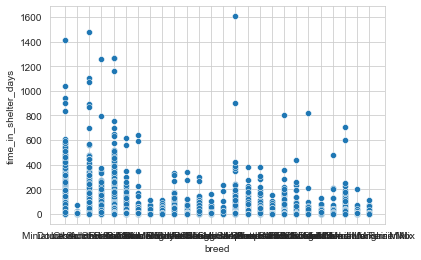

In [31]:
sns.scatterplot(x="breed", y="time_in_shelter_days", data=data) 

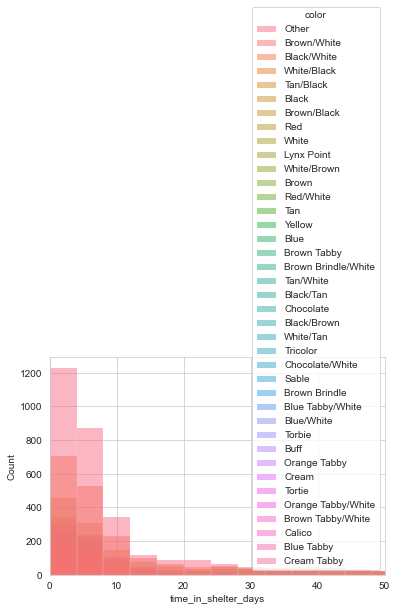

In [32]:
fig, ax = plt.subplots(1,1)
sns.histplot(x="time_in_shelter_days", hue= "color", data=data, bins=400)
ax.set_xlim((0,50))
plt.show()

<AxesSubplot:xlabel='time_in_shelter_days'>

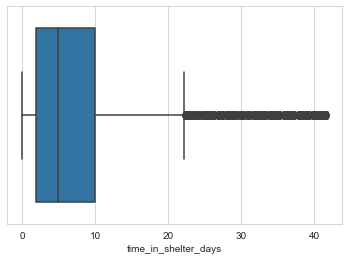

In [33]:
sns.boxplot(cleaned_outliers_time_in_shelter_days["time_in_shelter_days"])

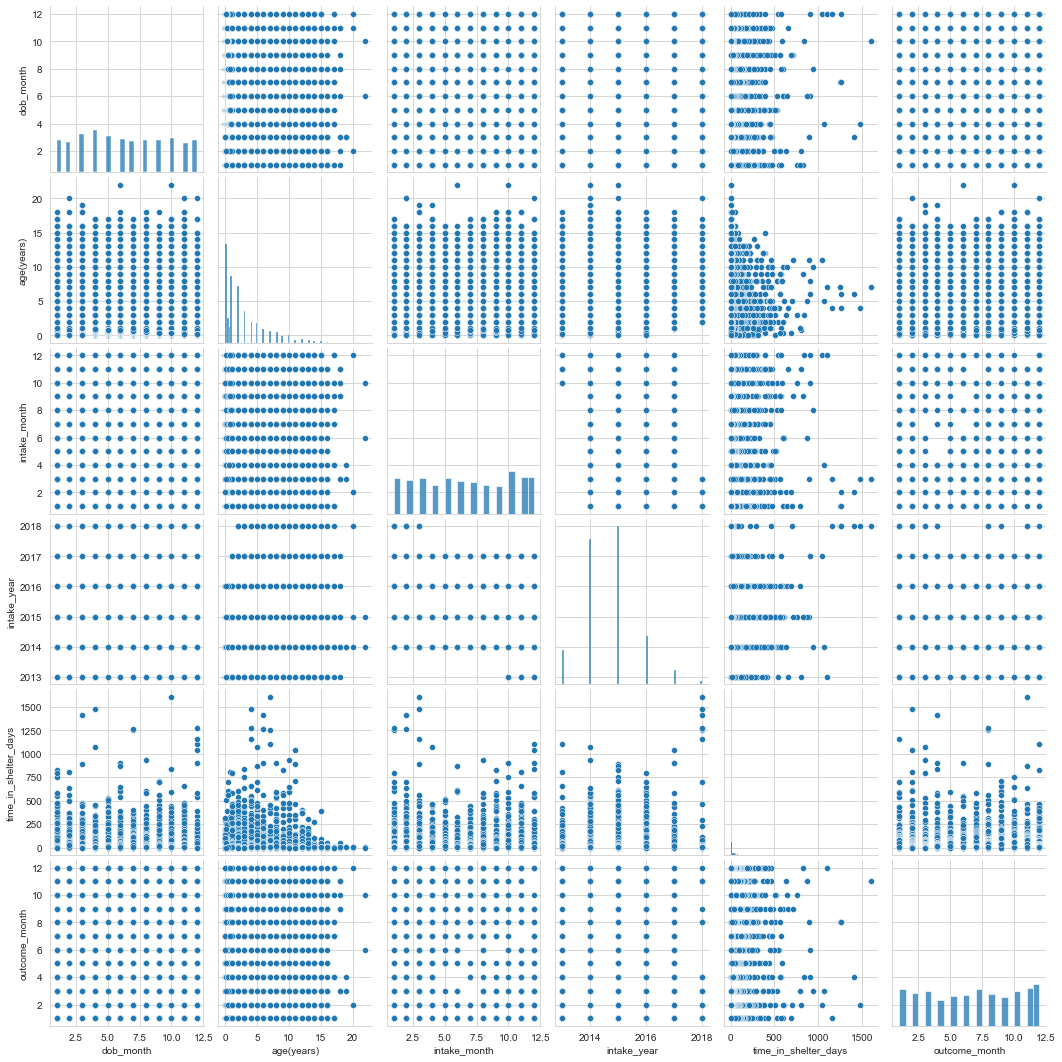

In [34]:
sns.pairplot(data)

# Feature Engineering

# Outlier Analysis

In [35]:
feature = "time_in_shelter_days"    # target feature                

In [36]:
# Function to scale categorical data, either with frequency encoding or dummification
def encoding(df, le):                                          # dataset, option to use frequency encoding
    numerical = df.select_dtypes(np.number)                                         # numerical data
    categorical = df.select_dtypes(object)                                          # categorical data
    if le:                                                                            # enable frequency encoding?
        for col in categorical.columns:
            categorical[col]=label.fit_transform(categorical[col])
    else: 
        categorical = pd.get_dummies(categorical, drop_first = True)                  # if frequency encoding was not enabled
                                                                                      # dummification of features will be used
        
    dfs = pd.concat([numerical, categorical] , axis = 1)           # concatenate both numerical and categorical dataframes
    return dfs                                                     # return data

In [37]:
def model_inplace(df, feature, scaler, model):
    X = df[df.columns.drop(feature)]  # features for regression
    y = df[feature]                     # target feature         
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train,y_train)
    print(scaler, model)
    print("train:", model.score(X_train, y_train))
    print("test:", model.score(X_test, y_test))
    try:
        feature_importance = pd.DataFrame({ 
        "feature_names": X.columns,
        "coefficients": abs(model.coef_)
        })
        feature_importance = feature_importance.sort_values(["coefficients"], ascending=False) # Ranking the features
    except:
        return np.nan
    return feature_importance

In [38]:
# different scaler
poly = PolynomialFeatures(degree=3)
label = LabelEncoder()
stdscal = StandardScaler()
minmax = MinMaxScaler()
scaler_list = [stdscal, minmax]

#different Regresser
lreg = LinearRegression()
ridge = Ridge(alpha = 200)
lasso = Lasso(alpha = 0)
reg_list = [lreg, ridge, lasso]

In [39]:
le = True
data_enc = encoding(data, le)
data_no_outl_enc = encoding(data_no_outl, le)
data_list = [data_enc, data_no_outl_enc]

In [40]:
for encoded in data_list:
    print("NEW DATA")
    for scaler in scaler_list:
        print("")
        for reg in reg_list:
            feature_importance = model_inplace(encoded, feature, scaler, reg)
            print("")
            display(feature_importance)
    print("------------------------------------")  

NEW DATA

StandardScaler() LinearRegression()
train: 0.046686507355910845
test: 0.029363776682533982



,feature_names,coefficients
14,outcome_type,7.367048
4,outcome_month,5.092463
5,animal_type,5.072852
2,intake_month,4.198588
8,intake_condition,3.324297
1,age(years),2.815215
12,sex_upon_outcome,2.751413
3,intake_year,2.218912
10,sex,2.087733
7,color,1.872426


StandardScaler() Ridge(alpha=200)
train: 0.046671340904326675
test: 0.029727017385881682



,feature_names,coefficients
14,outcome_type,7.289111
5,animal_type,5.018022
4,outcome_month,4.829930
2,intake_month,3.923652
8,intake_condition,3.281525
1,age(years),2.732234
12,sex_upon_outcome,2.725457
3,intake_year,2.204632
10,sex,2.043792
7,color,1.856410


StandardScaler() Lasso(alpha=0)
train: 0.046686507355910845
test: 0.02936377668253376



,feature_names,coefficients
14,outcome_type,7.367048
4,outcome_month,5.092463
5,animal_type,5.072852
2,intake_month,4.198588
8,intake_condition,3.324297
1,age(years),2.815215
12,sex_upon_outcome,2.751413
3,intake_year,2.218912
10,sex,2.087733
7,color,1.872426



MinMaxScaler() LinearRegression()
train: 0.046686507355910845
test: 0.02936377668253387



,feature_names,coefficients
8,intake_condition,39.109472
5,animal_type,32.416075
14,outcome_type,21.807623
1,age(years),19.024602
12,sex_upon_outcome,17.633511
4,outcome_month,15.658042
2,intake_month,13.045638
3,intake_year,11.472359
9,intake_type,8.159933
7,color,5.954679


MinMaxScaler() Ridge(alpha=200)
train: 0.04307209452290417
test: 0.029554329515852573



,feature_names,coefficients
5,animal_type,21.288837
14,outcome_type,20.385074
8,intake_condition,14.555819
12,sex_upon_outcome,11.625033
4,outcome_month,10.540489
3,intake_year,8.855301
1,age(years),8.624428
2,intake_month,7.926961
9,intake_type,7.187563
7,color,5.952823


MinMaxScaler() Lasso(alpha=0)
train: 0.046686507355910845
test: 0.02936377668253387



,feature_names,coefficients
8,intake_condition,39.109472
5,animal_type,32.416075
14,outcome_type,21.807623
1,age(years),19.024602
12,sex_upon_outcome,17.633511
4,outcome_month,15.658042
2,intake_month,13.045638
3,intake_year,11.472359
9,intake_type,8.159933
7,color,5.954679


------------------------------------
NEW DATA

StandardScaler() LinearRegression()
train: 0.1592725242442622
test: 0.1479274774155419



,feature_names,coefficients
14,outcome_type,2.070768
5,animal_type,1.641486
10,sex,1.115603
4,outcome_month,0.876268
12,sex_upon_outcome,0.606575
9,intake_type,0.532051
7,color,0.494556
2,intake_month,0.433595
11,intake_weekday,0.318639
1,age(years),0.272564


StandardScaler() Ridge(alpha=200)
train: 0.1592415217577826
test: 0.14806097253185935



,feature_names,coefficients
14,outcome_type,2.046920
5,animal_type,1.622522
10,sex,1.099896
4,outcome_month,0.804275
12,sex_upon_outcome,0.598625
9,intake_type,0.527194
7,color,0.489784
2,intake_month,0.361849
11,intake_weekday,0.313049
1,age(years),0.284693


StandardScaler() Lasso(alpha=0)
train: 0.15927252424426208
test: 0.1479274774155419



,feature_names,coefficients
14,outcome_type,2.070768
5,animal_type,1.641486
10,sex,1.115603
4,outcome_month,0.876268
12,sex_upon_outcome,0.606575
9,intake_type,0.532051
7,color,0.494556
2,intake_month,0.433595
11,intake_weekday,0.318639
1,age(years),0.272564



MinMaxScaler() LinearRegression()
train: 0.1592725242442622
test: 0.1479274774155419



,feature_names,coefficients
5,animal_type,10.891308
14,outcome_type,6.185357
12,sex_upon_outcome,3.785464
10,sex,3.100838
9,intake_type,2.714750
4,outcome_month,2.681975
1,age(years),1.825992
7,color,1.561304
8,intake_condition,1.470657
2,intake_month,1.332311


MinMaxScaler() Ridge(alpha=200)
train: 0.1531930264105822
test: 0.14326683031612886



,feature_names,coefficients
5,animal_type,6.848984
14,outcome_type,5.796806
10,sex,2.885632
12,sex_upon_outcome,2.439955
9,intake_type,2.315930
1,age(years),1.873235
4,outcome_month,1.692341
7,color,1.634392
6,breed,1.397525
11,intake_weekday,0.799218


MinMaxScaler() Lasso(alpha=0)
train: 0.1592725242442622
test: 0.1479274774155419



,feature_names,coefficients
5,animal_type,10.891308
14,outcome_type,6.185357
12,sex_upon_outcome,3.785464
10,sex,3.100838
9,intake_type,2.714750
4,outcome_month,2.681975
1,age(years),1.825992
7,color,1.561304
8,intake_condition,1.470657
2,intake_month,1.332311


------------------------------------


#### Score on Data without outliers is better.

In [41]:
X = data_no_outl_enc[data_no_outl_enc.columns.drop(feature)]  # features for regression
y = data_no_outl_enc[feature]                         # target feature         
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
X_train = stdscal.fit_transform(X_train)
X_test = stdscal.transform(X_test)

In [42]:
# learn is what is the best alhpa on Lasso
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(lasso, param_grid= params, cv=10, verbose=1)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Lasso", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Lasso", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces

Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [-0.11319933 -0.272564   -0.4335946  -0.16152171  0.87626805 -1.64148569
 -0.23798246 -0.49455623  0.11603441 -0.53205054 -1.11560332  0.31863888
  0.60657463 -0.06437733 -2.07076786]
score on train set: 0.15927252424426208
score on test set: 0.1479274774155419
columns that were removed by Lasso Index([], dtype='object')
columns that were NOT removed by Lasso Index(['dob_month', 'age(years)', 'intake_month', 'intake_year',
       'outcome_month', 'animal_type', 'breed', 'color', 'intake_condition',
       'intake_type', 'sex', 'intake_weekday', 'sex_upon_outcome',
       'outcome_weekday', 'outcome_type'],
      dtype='object')
best alpha {'alpha': 0}


In [43]:
# learn is what is the best alhpa on ridge
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(ridge,  param_grid= params, cv=10, verbose=1)
      
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Ridge", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Ridge", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces

Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [-0.11653392 -0.28469278 -0.36184932 -0.15995748  0.80427463 -1.62252212
 -0.24004378 -0.48978387  0.11507476 -0.52719435 -1.09989639  0.31304854
  0.59862519 -0.06410538 -2.04691994]
score on train set: 0.1592415217577826
score on test set: 0.14806097253185935
columns that were removed by Ridge Index([], dtype='object')
columns that were NOT removed by Ridge Index(['dob_month', 'age(years)', 'intake_month', 'intake_year',
       'outcome_month', 'animal_type', 'breed', 'color', 'intake_condition',
       'intake_type', 'sex', 'intake_weekday', 'sex_upon_outcome',
       'outcome_weekday', 'outcome_type'],
      dtype='object')
best alpha {'alpha': 200}


In [44]:
for i in range (3,7):
    neigh = KNeighborsRegressor(n_neighbors=i)
    model_inplace(data_no_outl_enc,feature,stdscal,neigh)

StandardScaler() KNeighborsRegressor(n_neighbors=3)
train: 0.5774608538288335
test: 0.1522811192480975
StandardScaler() KNeighborsRegressor(n_neighbors=4)
train: 0.5180470148189003
test: 0.18770370348587861
StandardScaler() KNeighborsRegressor()
train: 0.4774987320866809
test: 0.2028221743022668
StandardScaler() KNeighborsRegressor(n_neighbors=6)
train: 0.4501940389975193
test: 0.2216700878205562


In [45]:
model_inplace(data_no_outl_enc,feature,poly,lreg)

PolynomialFeatures(degree=3) LinearRegression()
train: 0.6043775009701717
test: 0.5277027735068913


nan

In [46]:
features = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names_out(X.columns))
display(features.head())

,1,dob_month,age(years),intake_month,intake_year,outcome_month,animal_type,breed,color,intake_condition,intake_type,sex,intake_weekday,sex_upon_outcome,outcome_weekday,outcome_type,dob_month^2,dob_month age(years),dob_month intake_month,dob_month intake_year,dob_month outcome_month,dob_month animal_type,dob_month breed,dob_month color,dob_month intake_condition,dob_month intake_type,dob_month sex,dob_month intake_weekday,dob_month sex_upon_outcome,dob_month outcome_weekday,dob_month outcome_type,age(years)^2,age(years) intake_month,age(years) intake_year,age(years) outcome_month,age(years) animal_type,age(years) breed,age(years) color,age(years) intake_condition,age(years) intake_type,age(years) sex,age(years) intake_weekday,age(years) sex_upon_outcome,age(years) outcome_weekday,age(years) outcome_type,intake_month^2,intake_month intake_year,intake_month outcome_month,intake_month animal_type,intake_month breed,intake_month color,intake_month intake_condition,intake_month intake_type,intake_month sex,intake_month intake_weekday,intake_month sex_upon_outcome,intake_month outcome_weekday,intake_month outcome_type,intake_year^2,intake_year outcome_month,intake_year animal_type,intake_year breed,intake_year color,intake_year intake_condition,intake_year intake_type,intake_year sex,intake_year intake_weekday,intake_year sex_upon_outcome,intake_year outcome_weekday,intake_year outcome_type,outcome_month^2,outcome_month animal_type,outcome_month breed,outcome_month color,outcome_month intake_condition,outcome_month intake_type,outcome_month sex,outcome_month intake_weekday,outcome_month sex_upon_outcome,outcome_month outcome_weekday,outcome_month outcome_type,animal_type^2,animal_type breed,animal_type color,animal_type intake_condition,animal_type intake_type,animal_type sex,animal_type intake_weekday,animal_type sex_upon_outcome,animal_type outcome_weekday,animal_type outcome_type,breed^2,breed color,breed intake_condition,breed intake_type,breed sex,breed intake_weekday,breed sex_upon_outcome,breed outcome_weekday,breed outcome_type,color^2,color intake_condition,color intake_type,color sex,color intake_weekday,color sex_upon_outcome,color outcome_weekday,color outcome_type,intake_condition^2,intake_condition intake_type,intake_condition sex,intake_condition intake_weekday,intake_condition sex_upon_outcome,intake_condition outcome_weekday,intake_condition outcome_type,intake_type^2,intake_type sex,intake_type intake_weekday,intake_type sex_upon_outcome,intake_type outcome_weekday,intake_type outcome_type,sex^2,sex intake_weekday,sex sex_upon_outcome,sex outcome_weekday,sex outcome_type,intake_weekday^2,intake_weekday sex_upon_outcome,intake_weekday outcome_weekday,intake_weekday outcome_type,sex_upon_outcome^2,sex_upon_outcome outcome_weekday,sex_upon_outcome outcome_type,outcome_weekday^2,outcome_weekday outcome_type,outcome_type^2,dob_month^3,dob_month^2 age(years),dob_month^2 intake_month,dob_month^2 intake_year,dob_month^2 outcome_month,dob_month^2 animal_type,dob_month^2 breed,dob_month^2 color,dob_month^2 intake_condition,dob_month^2 intake_type,dob_month^2 sex,dob_month^2 intake_weekday,dob_month^2 sex_upon_outcome,dob_month^2 outcome_weekday,dob_month^2 outcome_type,dob_month age(years)^2,dob_month age(years) intake_month,dob_month age(years) intake_year,dob_month age(years) outcome_month,dob_month age(years) animal_type,dob_month age(years) breed,dob_month age(years) color,dob_month age(years) intake_condition,dob_month age(years) intake_type,dob_month age(years) sex,dob_month age(years) intake_weekday,dob_month age(years) sex_upon_outcome,dob_month age(years) outcome_weekday,dob_month age(years) outcome_type,dob_month intake_month^2,dob_month intake_month intake_year,dob_month intake_month outcome_month,dob_month intake_month animal_type,dob_month intake_month breed,dob_month intake_month color,dob_month intake_month intake_condition,dob_month intake_month intake_type,dob_month intake_month sex,dob_month intake_month int

## comparing model scores

In [47]:
# safe scores from previous attempts in a dictionary
rms = {'Model used' : ['LinearRegression', 'Lasso(alpha = 0)', 'Ridge(alpha = 200)', 'KNeighboursRegressor(n = 6)'],
    'Train score' : [0.159,0.159,0.158,0.449],
    'Test score' : [0.148,0.148,0.148,0.222],
}
regression_model_scores = pd.DataFrame(data=rms)
regression_model_scores

,Model used,Train score,Test score
0,LinearRegression,0.159,0.148
1,Lasso(alpha = 0),0.159,0.148
2,Ridge(alpha = 200),0.158,0.148
3,KNeighboursRegressor(n = 6),0.449,0.222


#### PolynomialFeatures(degree=3) LinearRegression()
#### train: 0.605
#### test: 0.529

# We created a model with an r2-score of about 0.6 for train and 0.53 for test data. Using PolynomialFeatures scaler, LinearRegression and removing outliers.

## confidence intervals

In [48]:
tisd = data_no_outl["time_in_shelter_days"]
age = data_no_outl["age(years)"]

In [49]:
tisd

0         0.588194
1        23.104861
2         0.029167
3         4.199306
4         4.804861
           ...    
20979     0.324306
20980     0.204167
20981     0.068750
20982     0.019444
20983    21.525000
Name: time_in_shelter_days, Length: 18070, dtype: float64

In [50]:
tisd.mean()

7.947093286908884

In [51]:
def ci(data):
    n = len(data)
    mean = data.mean()
    std = data.std()
    t = stats.t.ppf(0.975, df = n-1)
    error = t * (std/m.sqrt(n))
    confidence_interval = [mean - error, mean + error]
    return confidence_interval

In [52]:
ci_tisd = ci(tisd)
ci_tisd

[7.814507866234631, 8.079678707583136]

In [53]:
ci_age = ci(age)
ci_age

[2.7738268008407574, 2.8702341190214544]

In [55]:
tableau = data_no_outl.copy()
tableau.to_excel("Animal_Welfare_Center.xlsx", index = False)